# PIK3CA trans effects on known interacting proteins

We investigated the effects of PIK3CA mutation on the proteomics and phosphoproteomic of all proteins in our dataframes. 

We compare the proteomics and phosphoproteomics of patients with mutations in the PIK3CA hotspot with cancer patients with no PIK3CA mutation (cancer wildtype) and also all patients with any PIK3CA mutation with cancer wildtype.

## Standard Imports

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import json
import operator

#import the Endometrial data from CPTAC package
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list(). In order to access a specific data set,
import a CPTAC subfolder using either 'import CPTAC.Dataset' or 'from
CPTAC import Dataset'.
******
Version: 0.2.5
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


# 1. Set up initial dataframes and variables

In [2]:
gene = 'PIK3CA'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']

#
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

hotspot_patients_both_keys = mutated_hotspot[['Clinical_Patient_Key', 'Patient_Id']]
hotspot_patients = hotspot_patients_both_keys['Clinical_Patient_Key']
print(hotspot_patients)

#The pvalue cutoff used to find significance
pcutoff = 0.05


160      S001
1147     S003
1357     S009
4630     S021
16486    S023
19061    S024
21259    S032
21516    S033
22497    S038
37421    S061
38155    S063
39522    S066
43391    S067
43490    S068
46662    S084
47360    S088
47857    S090
49362    S097
49475    S098
Name: Clinical_Patient_Key, dtype: object


# 2. Find number of patients with PIK3CA mutations in/outside of the hotspot

In [3]:
print("Mutations inside hotspot: " + str(len(hotspot_patients)))
p110_mutated = somatic.loc[somatic['Gene'] == 'PIK3CA']
#note: the gene PIK3CA encodes for the protein p110α, hence the variable 'p110_mutated'

# This naturally includes a value that is 'NA' so we subtract 1
# Some people have more than one mutation so we need to grab the unique values
num_mutated = len(set(p110_mutated['Clinical_Patient_Key'])) - 1
print("Total number of patients with mutations: " + str(num_mutated))

Mutations inside hotspot: 19
Total number of patients with mutations: 46


# 3. Create list for all proteins in proteomics dataframe and all phosphosites in phosphoproteomics dataframe

In [4]:
#Build the protein list; this may have only a single protein if desired
protList = proteomics.columns
phosprotList = phos.columns

# 4. Proteomic Abundance

## 4a. Hotspot mutations vs cancer wildtype

In [5]:
print("Mutations inside hotspot: " + str(len(hotspot_patients)))
p110_mutated = somatic.loc[somatic['Gene'] == 'PIK3CA']

# 1. Use the Bonferonni correction to adjust the p-value by dividing alpha (0.05) by the number of tests. 
pcutoff = 0.05/len(protList)
print('\nAdjusted p-value: ', pcutoff, '\n')

# 2. Create a dictionary for significant proteins with their prespective pvalues
#    Create another dictionary for unsignificant results
sigResults = {}
unsigResults = {}

# 3. Loop through each protein to test for significant protein level
for protein in protList: 
    
    #Check to make sure that the protein is in the proteomics dataframe that we are reading from
    if protein in proteomics.columns:
        # 4. Set up a new column for mutations that are within the hotspot
        p110_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
        p110_mutations['Within_Hotspot'] = False
        p110_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
        p110_mutations.loc[p110_mutations['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype_Tumor'
        p110_mutations = p110_mutations.loc[p110_mutations['Sample_Status'] == 'Tumor'].dropna(axis=0)

        #Create two dataframes - one for mutations within the PIK3CA hotspot and another for cancer wildtype (no PIK3CA mutation)
        in_hotspot = p110_mutations.loc[p110_mutations['Within_Hotspot'] == True]
        wt = p110_mutations.loc[p110_mutations['Within_Hotspot'] == 'Wildtype_Tumor']
        
        # 5. Perform a two-sample ttest for mutations in hotspot vs mutations outside of the hotspot
        ttest = scipy.stats.ttest_ind(in_hotspot[protein], wt[protein])
        
         # If the resulting p-value is lower than the Bonferroni-adjusted p-value cutoff, add it to the significant results dictionary. Otherwise, add it to the unsignificant dictionary.
        if ttest[1] < pcutoff:
            sigResults[protein] = ttest[1]
        else:
            unsigResults[protein] = ttest[1]
            
#5. Sort the dictionaries 
sigResults = sorted(sigResults.items(), key=operator.itemgetter(1))
unsigResults = sorted(unsigResults.items(), key=operator.itemgetter(1))
            
# 6. Print the results
print('SIGNIFICANT RESULTS:')
# Json is a nice package that allows you to print items in the dictionary line by line
# Because the list is excessive, print out the 100 lowest p-values 
print(json.dumps(sigResults[0:100], indent = 2))
print(' ')
print('UNSIGNIFICANT RESULTS:')
print(json.dumps(unsigResults[0:100], indent = 2))


Mutations inside hotspot: 19

Adjusted p-value:  4.545867806164197e-06 



/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


SIGNIFICANT RESULTS:
[]
 
UNSIGNIFICANT RESULTS:
[
  [
    "ARAP2",
    0.0009672291705983455
  ],
  [
    "ATP13A3",
    0.003698842116988185
  ],
  [
    "ATP11B",
    0.005590963654763756
  ],
  [
    "ATP6V0C",
    0.007098942046053622
  ],
  [
    "ARX",
    0.00773231023319682
  ],
  [
    "ATG2B",
    0.009704850126057001
  ],
  [
    "ANTXR2",
    0.012571276865908913
  ],
  [
    "ANO6",
    0.013265994305542303
  ],
  [
    "AMFR",
    0.013818795359024307
  ],
  [
    "ATG4C",
    0.01432967242960138
  ],
  [
    "ABL1",
    0.014413649019528466
  ],
  [
    "AMOTL2",
    0.017971126183593686
  ],
  [
    "BCAS2",
    0.018393215955297453
  ],
  [
    "ASNA1",
    0.021225332519735365
  ],
  [
    "ATP9B",
    0.022599378144587078
  ],
  [
    "BCL11A",
    0.03150897060581889
  ],
  [
    "ATP1A2",
    0.034795515783355845
  ],
  [
    "ATP5IF1",
    0.04156539201861945
  ],
  [
    "ANP32A",
    0.04798761681182711
  ],
  [
    "BCAP29",
    0.0497355992459621
  ],
  [
   

## 4b. Plot the data for the most significant result

<b> Note: </b> This result did not pass the Bonferroni correction of significance. This is the lowest p-value found in our list of unsignificant results.

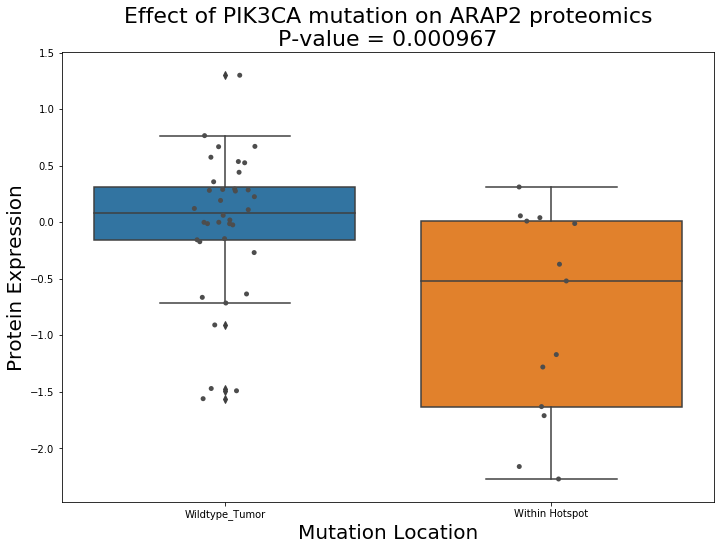

In [11]:
#Get the protein with the lowest p-value, which is the first element in the unsigResults list computer above
protein = unsigResults[0][0]


#Get the ttest results computed from the previous step, using ARAP2 as the protein of interest
p110_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
p110_mutations['Within_Hotspot'] = 'Outside Hotspot'
p110_mutations.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p110_mutations.loc[p110_mutations['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype_Tumor'
p110_mutations = p110_mutations.loc[p110_mutations['Sample_Status'] == 'Tumor'].dropna(axis=0)
p110_mutations = p110_mutations.loc[p110_mutations['Within_Hotspot'] != 'Outside Hotspot']

#perform a ttest to get the resulting pvalue
in_hotspot = p110_mutations.loc[p110_mutations['Within_Hotspot'] == 'Within Hotspot']
wt = p110_mutations.loc[p110_mutations['Within_Hotspot'] == 'Wildtype_Tumor']
        
ttest = scipy.stats.ttest_ind(in_hotspot[protein], wt[protein])

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p110_mutations, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = p110_mutations, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " proteomics" + '\nP-value = ' + str(round(ttest[1],  6)), fontsize='22')
plt.show()

## 4c. All mutations vs cancer wildtype

In [13]:
# 1. Use the Bonferonni correction to adjust the p-value by dividing alpha (0.05) by the number of tests. 
    
pcutoff = 0.05/len(protList)
print('Adjusted p-value: ', pcutoff, '\n')

# 2. Create a dictionary for significant proteins with their prespective pvalues
#    Create another dictionary for unsignificant results
sigResults = {}
unsigResults = {}

# 3. Loop through each protein to test for significant protein level
for protein in protList: 
    
    #Check to make sure that the protein is in the proteomics dataframe that we are reading from
    if protein in proteomics.columns:
        # 4. Set up a new column for mutations that are within the hotspot
        p110_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
        
        # 5. Take out the normal samples
        p110_mutations = p110_mutations.loc[p110_mutations['Sample_Status'] == 'Tumor'].dropna(axis=0)

        # 6. Create two dataframes - one for PIK3CA mutations and Cancer Wildtype (no PIK3CA mutation)
        all_mut = p110_mutations.loc[p110_mutations['Mutation'] != 'Wildtype_Tumor']
        wt = p110_mutations.loc[p110_mutations['Mutation'] == 'Wildtype_Tumor']
        
        # 7. Perform a two-sample ttest for mutations in hotspot vs mutations outside of the hotspot
        ttest = scipy.stats.ttest_ind(all_mut[protein], wt[protein])
        
        # If the resulting p-value is lower than the Bonferroni-adjusted p-value cutoff, add it to the significant results dictionary. 
        if ttest[1] < pcutoff:
            sigResults[protein] = ttest[1]
        # Otherwise, add it to the unsignificant dictionary. 
        else:
            unsigResults[protein] = ttest[1]

#8. Sort the dictionaries 
sigResults = sorted(sigResults.items(), key=operator.itemgetter(1))
unsigResults = sorted(unsigResults.items(), key=operator.itemgetter(1))
            
# 9. Print the results
print('SIGNIFICANT RESULTS:')
# Json is a nice package that allows you to print items in the dictionary line by line
# Because the list is excessive, print out the 100 lowest p-values 
print(json.dumps(sigResults[:100], indent = 2))
print(' ')
print('UNSIGNIFICANT RESULTS:')
print(json.dumps(unsigResults[:100], indent = 2))


Adjusted p-value:  4.545867806164197e-06 

SIGNIFICANT RESULTS:
[]
 
UNSIGNIFICANT RESULTS:
[
  [
    "CCDC25",
    0.00085794811184464
  ],
  [
    "KLF6",
    0.0011177119766709782
  ],
  [
    "EIF3K",
    0.001329415240582395
  ],
  [
    "FOXA1",
    0.003157912096516399
  ],
  [
    "HBS1L",
    0.006186645609703834
  ],
  [
    "CHST4",
    0.0086613123246615
  ],
  [
    "CDKL5",
    0.009883131902439071
  ],
  [
    "FGR",
    0.010585235474021624
  ],
  [
    "CHIC2",
    0.011321456581421186
  ],
  [
    "CHIT1",
    0.01235587143398541
  ],
  [
    "CHD6",
    0.012593619606133316
  ],
  [
    "FAM84B",
    0.013571264781865636
  ],
  [
    "CTSW",
    0.013852630387924775
  ],
  [
    "COL6A3",
    0.014262865294538105
  ],
  [
    "FAM160B2",
    0.015207824113376437
  ],
  [
    "ERF",
    0.01617079254390483
  ],
  [
    "FBXO4",
    0.016636385375367192
  ],
  [
    "ELOF1",
    0.016662098931141293
  ],
  [
    "ALDH7A1",
    0.01684515796427523
  ],
  [
    "AGTPBP1"

## 4d. Plot the data for the most significant result

<b> Note: </b> This result did not pass the Bonferroni correction of significance. This is the lowest p-value found in our list of unsignificant results.

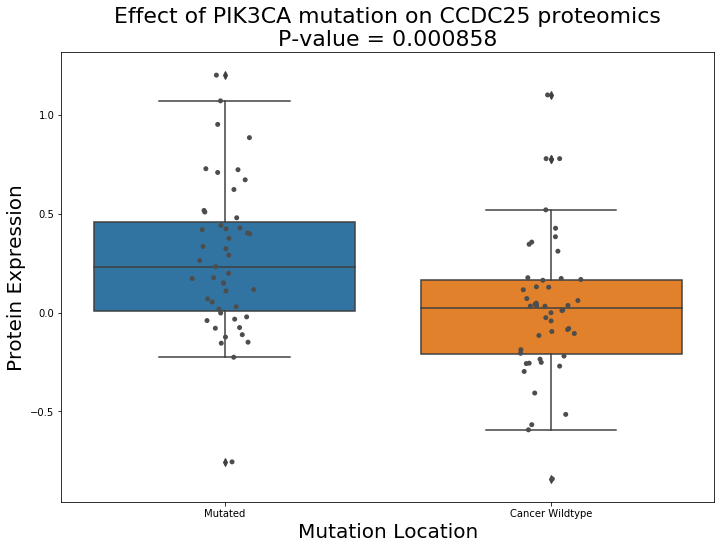

In [15]:
#Get the protein with the lowest p-value, which is the first element in the unsigResults list computer above
protein = unsigResults[0][0]

#Get the ttest results computed from the previous step, using CCDC25 as the protein of interest
p110_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
p110_mutations = p110_mutations.loc[p110_mutations['Sample_Status'] == 'Tumor'].dropna(axis=0)

# Because we are comparing all mutations and cancer wildtype, create another column that categorizes each patient as 'mutated' or 'wildtype_tumor' 
p110_mutations['Status'] = 'Cancer Wildtype'
p110_mutations.loc[p110_mutations['Mutation'] != 'Wildtype_Tumor', 'Status'] = 'Mutated'

#Create two dataframes - one for mutated PIK3CA and another for cancer wildtype (no PIK3CA mutation)
mutated = p110_mutations.loc[p110_mutations['Status'] == 'Mutated']
wt = p110_mutations.loc[p110_mutations['Status'] == 'Cancer Wildtype']

#perform a ttest to get the resulting pvalue
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])

#Plot the results using the seaborn package
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p110_mutations, x = 'Status', y = protein, ax = ax)
boxplt = sns.stripplot(data = p110_mutations, x = 'Status', y = protein, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " proteomics" + '\nP-value = ' + str(round(ttest[1],  6)), fontsize='22')
plt.show()

# 5. Phosphoproteomic Abundance

## 5a. Hotspot mutation vs cancer wildtype

In [17]:
#1. Create two corresponding lists for sites and their respective pvalues to calculate the Bonferroni correction when all of the sites have been analyzed
sites = []
pvalues = []
tstats = []


# 2. Loop through each of the proteins in the list of interacting proteins
for protein in phosprotList:
   # 3. Loop through each phosphorylation site in that protein to find any that show any significant changes in phosphorylation level
    #  Some proteins do not have recorded data in the phosphoproteomics data. If this is the case, we move on to the next protein in the list
    try:
        
        # 4. Set up a new column for mutations that are within the hotspot
        phos_mutations = CPTAC.compare_mutations(phos, protein, gene)
        phos_mutations['Within_Hotspot'] = False
        phos_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
        phos_mutations.loc[phos_mutations['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype_Tumor'
        
        # 5. Select for tumor samples only 
        phos_mutations = phos_mutations.loc[phos_mutations['Sample_Status'] == 'Tumor']
       
        # 6. Create a list of the phosphosites by selecting all the columns in the dataframe, excluding the last three which are categorical variables
        phos_sites = list(phos_mutations)
        # Take out the categorical variables, which are 'Mutation', 'Sample_Status', and 'Within_Hotspot'
        phos_sites = phos_sites[:(len(phos_sites) - 3)]

        # 7. Create two dataframes to test the two cases: one for phosphorylation levels when PIK3CA is mutated at a hotspot, the other when PIK3CA is mutated outside the hotspot
        #    Drop any columns that contain values of 'Nan' which means for 'Not a number'
        hotspot_mut = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True].dropna(axis = 1)
        wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == 'Wildtype_Tumor'].dropna(axis = 1)

        # 8. Loop through each site to test for significant difference in phosphorylation levels between the two tested cases
        for site in phos_sites:

        # 9. Check if the site is in both dataframes. That column may have been deleted in step 4
            if site in hotspot_mut.columns and site in wt.columns:
                
                # 10. Perform a two-sample ttest for mutations in hotspot vs cancer wildtype
                tstat, pvalue = scipy.stats.ttest_ind(hotspot_mut[site], wt[site])
                
                # 11. Append site name and pvalue in two separate lists that will be used to calculate the pvalue adjustment using Bonferroni correction
                sites.append(site)
                pvalues.append(pvalue)
                tstats.append(tstat)
    #Error caught in the case that the protein had no data in the phosproteomics data
    except:
        print('')
        
        
# 12. After looping through all of the phosphorylation sites of each protein, filter the list of pvalues with respective sites to find those with significant results
#     Create a dictionary to pair the significant sites with their significant pvalues 
#     Create another dictionary for unsignificant results
sigSites = {}
unsigSites = {}

#     The Bonferroni correction is alpha/number of sites tested
alpha = 0.05
pcutoff = alpha/len(sites)
print('{}' '{}' '{}'.format('\nAdjusted p-value: ', pcutoff, '\n'))

#     Loop through each pvalue to find those that are lower than the pcutoff
for i in range(0, len(sites) - 1):
    if pvalues[i] < pcutoff:
        sigSites[sites[i]] = pvalues[i]
    else:
        unsigSites[sites[i]] = pvalues[i]

# 13. Sort the dictionaries 
sigResults = sorted(sigResults.items(), key=operator.itemgetter(1))
unsigResults = sorted(unsigResults.items(), key=operator.itemgetter(1))

# 14. Print your results
print('SIGNIFICANT RESULTS:')
print(json.dumps(sigSites[:100], indent = 2))
print(' ')
print('UNSIGNIFICANT RESULTS:')
print(json.dumps(unsigSites[:100], indent = 2))



Adjusted p-value:  7.191140514885661e-06 



AttributeError: 'list' object has no attribute 'items'

## 5b. Plot the data for the most significant result

In [ ]:
#Get the site with the lowest p-value 
site = min(unsigSites.keys(), key=(lambda k: unsigSites[k]))

#Get the ttest results computed from the previous step, using RPS6KC1-S423 as the site of interest
phos_mutations = CPTAC.compare_mutations(phos, site, gene)
phos_mutations['Within_Hotspot'] = 'Outside Hotspot'
phos_mutations.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
phos_mutations.loc[phos_mutations['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype_Tumor'

# Select for tumor samples only 
phos_mutations = phos_mutations.loc[phos_mutations['Sample_Status'] == 'Tumor']

# Create a list of the phosphosites by selecting all the columns in the dataframe, excluding the last three which are categorical variables

# Take out the categorical variables, which are 'Mutation', 'Sample_Status', and 'Within_Hotspot'
phos_sites = phos_sites[:(len(phos_sites) - 3)]

#  Create two dataframes to test the two cases: one for phosphorylation levels when PIK3CA is mutated at a hotspot, the other when PIK3CA is mutated outside the hotspot
#    Drop any columns that contain values of 'Nan' which means for 'Not a number'
hotspot_mut = phos_mutations.loc[phos_mutations['Within_Hotspot'] == 'Within Hotspot'].dropna(axis = 1)
wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == 'Wildtype_Tumor'].dropna(axis = 1)

# Take out the patients with mutations outside of the hotspot
phos_mutations = phos_mutations.loc[phos_mutations['Within_Hotspot'] != 'Outside Hotspot']

ttest = scipy.stats.ttest_ind(hotspot_mut[site], wt[site])

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = site, ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = site, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + site + " proteomics" + '\nP-value = ' + str(round(ttest[1],  6)), fontsize='22')
plt.show()

## 5c. All mutations vs cancer wildtype

In [ ]:
#1. Create two corresponding lists for sites and their respective pvalues to calculate the Bonferroni correction when all of the sites have been analyzed
sites = []
pvalues = []


# 2. Loop through each of the proteins in the list of interacting proteins
for protein in phosprotList:
   # 3. Loop through each phosphorylation site in that protein to find any that show any significant changes in phosphorylation level
    #  Some proteins do not have recorded data in the phosphoproteomics data. If this is the case, we move on to the next protein in the list
    try:
        
        # 4. Set up a new column for mutations that are within the hotspot
        phos_mutations = CPTAC.compare_mutations(phos, protein, gene)
        phos_mutations['Within_Hotspot'] = False
        phos_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
        phos_mutations.loc[phos_mutations['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype_Tumor'
        
        # 5. Select for tumor samples only 
        phos_mutations = phos_mutations.loc[phos_mutations['Sample_Status'] == 'Tumor']
       
        # 6. Create a list of the phosphosites by selecting all the columns in the dataframe, excluding the last three which are categorical variables
        phos_sites = list(phos_mutations)
        # Take out the categorical variables, which are 'Mutation', 'Sample_Status', and 'Within_Hotspot'
        phos_sites = phos_sites[:(len(phos_sites) - 3)]

        # 7. Create two dataframes to test the two cases: one for phosphorylation levels when PIK3CA is mutated at a hotspot, the other when PIK3CA is mutated outside the hotspot
        #    Drop any columns that contain values of 'Nan' which means for 'Not a number'
        all_mut = phos_mutations.loc[phos_mutations['Within_Hotspot'] != 'Wildtype_Tumor'].dropna(axis = 1)
        wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == 'Wildtype_Tumor'].dropna(axis = 1)

        # 8. Loop through each site to test for significant difference in phosphorylation levels between the two tested cases
        for site in phos_sites:

        # 9. Check if the site is in both dataframes. That column may have been deleted in step 4
            if site in all_mut.columns and site in wt.columns:
                
                # 10. Perform a two-sample ttest for all mutations vs cancer wildtype
                ttest = scipy.stats.ttest_ind(all_mut[site], wt[site])
                
                # 11. Append site name and pvalue in two separate lists that will be used to calculate the pvalue adjustment using Bonferroni correction
                sites.append(site)
                pvalues.append(ttest[1])
    #Error caught in the case that the protein had no data in the phosproteomics data
    except:
        print('')
        
        
# 12. After looping through all of the phosphorylation sites of each protein, filter the list of pvalues with respective sites to find those with significant results
#     Create a dictionary to pair the significant sites with their significant pvalues 
#     Create another dictionary for unsignificant results
sigSites = {}
unsigSites = {}

#     The Bonferroni correction is alpha/number of sites tested
alpha = 0.05
pcutoff = alpha/len(sites)
print('\nAdjusted p-value: ', pcutoff, '\n')

#     Loop through each pvalue to find those that are lower than the pcutoff
for i in range(0, len(sites) - 1):
    if pvalues[i] < pcutoff:
        sigSites[sites[i]] = pvalues[i]
    else:
        unsigSites[sites[i]] = pvalues[i]

# 13. Print your results
print('SIGNIFICANT RESULTS:')
print(json.dumps(sigSites, indent = 2))
print(' ')
print('UNSIGNIFICANT RESULTS:')
print(json.dumps(unsigSites, indent = 2))

## 5d. Plot the data for the most significant results

In [ ]:
#Get the site with the lowest p-value 
site = min(unsigSites.keys(), key=(lambda k: unsigSites[k]))

#Get the dataframe for the site of interest
phos_mutations = CPTAC.compare_mutations(phos, site, gene)

# Select for tumor samples only 
phos_mutations = phos_mutations.loc[phos_mutations['Sample_Status'] == 'Tumor']


#   Create two dataframes to test the two cases: one for phosphorylation levels when PIK3CA is mutated at a hotspot, the other when PIK3CA is mutated outside the hotspot
#    Drop any columns that contain values of 'Nan' which means for 'Not a number'
phos_mutations['Status'] = 'Cancer Wildtype'
phos_mutations.loc[phos_mutations['Mutation'] != 'Wildtype_Tumor', 'Status'] = 'Mutated'



hotspot_mut = phos_mutations.loc[phos_mutations['Status'] == 'Mutated'].dropna(axis = 1)
wt = phos_mutations.loc[phos_mutations['Status'] == 'Cancer Wildtype'].dropna(axis = 1)


ttest = scipy.stats.ttest_ind(hotspot_mut[site], wt[site])

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Status', y = site, ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Status', y = site, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Type', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + site + " phosphoproteomics" + '\nP-value = ' + str(round(ttest[1],  6)), fontsize='22')
plt.show()


### We can conclude from these results that PIK3CA mutation, neither hotspot no non-hotspot mutations, do not have a significant effect on the proteomics or phosproteomics of the any proteins in our data. 